In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

In [2]:
train_df = pd.read_csv('H1small.csv')
a=train_df.head()
b=train_df
b
b.sort_values(['ArrivalDateYear','ArrivalDateWeekNumber'], ascending=True)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
54,0,79,2015,July,27,4,4,6,2,1,...,No Deposit,250,NULL,0,Transient,149.00,0,1,Check-Out,2015-07-14
72,0,0,2015,July,29,13,1,1,4,0,...,No Deposit,NULL,NULL,0,Transient,150.00,0,0,Check-Out,2015-07-15
12,0,70,2015,August,31,1,2,5,2,0,...,No Deposit,250,NULL,0,Transient,187.14,0,0,Check-Out,2015-08-08
91,0,49,2015,July,31,28,1,5,2,0,...,No Deposit,241,NULL,0,Transient,103.18,0,1,Check-Out,2015-08-03
64,0,0,2015,August,35,24,1,0,2,0,...,No Deposit,NULL,NULL,0,Transient,153.00,0,0,Check-Out,2015-08-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,1,42,2017,July,29,17,2,5,2,2,...,No Deposit,240,NULL,0,Transient,342.29,0,0,Canceled,2017-06-21
77,1,55,2017,July,29,17,3,8,2,0,...,No Deposit,250,NULL,0,Transient,260.00,0,0,Canceled,2017-05-29
98,1,159,2017,July,29,22,2,5,2,0,...,No Deposit,240,NULL,0,Transient,192.00,0,0,Canceled,2017-02-16
93,0,25,2017,August,32,6,4,10,2,0,...,No Deposit,40,NULL,0,Group,114.76,0,2,Check-Out,2017-08-20


In [3]:
# Interval variables
leadtime = train_df['LeadTime']
arrivaldateyear = train_df['ArrivalDateYear']
arrivaldateweekno = train_df['ArrivalDateWeekNumber']
arrivaldatedayofmonth = train_df['ArrivalDateDayOfMonth']
staysweekendnights = train_df['StaysInWeekendNights']
staysweeknights = train_df['StaysInWeekNights']
adults = train_df['Adults']
children = train_df['Children']
babies = train_df['Babies']
isrepeatedguest = train_df['IsRepeatedGuest'] 
previouscancellations = train_df['PreviousCancellations']
previousbookingsnotcanceled = train_df['PreviousBookingsNotCanceled']
bookingchanges = train_df['BookingChanges']
agent = train_df['Agent']
company = train_df['Company']
dayswaitinglist = train_df['DaysInWaitingList']
adr = train_df['ADR']
rcps = train_df['RequiredCarParkingSpaces']
totalsqr = train_df['TotalOfSpecialRequests']

In [4]:
y1 = np.array(adr)

In [5]:
# Categorical variables
IsCanceled = train_df['IsCanceled']
arrivaldatemonth = train_df.ArrivalDateMonth.astype("category").cat.codes
arrivaldatemonthcat=pd.Series(arrivaldatemonth)
mealcat=train_df.Meal.astype("category").cat.codes
mealcat=pd.Series(mealcat)
countrycat=train_df.Country.astype("category").cat.codes
countrycat=pd.Series(countrycat)
marketsegmentcat=train_df.MarketSegment.astype("category").cat.codes
marketsegmentcat=pd.Series(marketsegmentcat)
distributionchannelcat=train_df.DistributionChannel.astype("category").cat.codes
distributionchannelcat=pd.Series(distributionchannelcat)
reservedroomtypecat=train_df.ReservedRoomType.astype("category").cat.codes
reservedroomtypecat=pd.Series(reservedroomtypecat)
assignedroomtypecat=train_df.AssignedRoomType.astype("category").cat.codes
assignedroomtypecat=pd.Series(assignedroomtypecat)
deposittypecat=train_df.DepositType.astype("category").cat.codes
deposittypecat=pd.Series(deposittypecat)
customertypecat=train_df.CustomerType.astype("category").cat.codes
customertypecat=pd.Series(customertypecat)
reservationstatuscat=train_df.ReservationStatus.astype("category").cat.codes
reservationstatuscat=pd.Series(reservationstatuscat)

In [6]:
x1 = np.column_stack((IsCanceled,countrycat,marketsegmentcat,deposittypecat,customertypecat,rcps,arrivaldateweekno))
x1 = sm.add_constant(x1, prepend=True)

In [7]:
#Variables
y1=np.reshape(y1, (-1,1))
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
print(scaler_x.fit(x1))
xscale=scaler_x.transform(x1)
print(scaler_y.fit(y1))
yscale=scaler_y.transform(y1)

MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))


In [8]:
y1.shape

(100, 1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(xscale, yscale)

In [10]:
y_train.shape

(75, 1)

In [11]:
model = Sequential()
model.add(Dense(8, input_dim=8, kernel_initializer='normal', activation='elu'))
model.add(Dense(5, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 45        
_________________________________________________________________
dropout (Dropout)            (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 123
Trainable params: 123
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
history=model.fit(X_train, y_train, epochs=30, batch_size=150,  verbose=1, validation_split=0.2)
predictions = model.predict(X_test)

Epoch 1/30
1/1 [==============================] - 0s 115ms/step - loss: 0.1294 - mse: 0.1294 - mae: 0.3076 - val_loss: 0.1199 - val_mse: 0.1199 - val_mae: 0.3194
Epoch 2/30
1/1 [==============================] - 0s 17ms/step - loss: 0.1245 - mse: 0.1245 - mae: 0.2986 - val_loss: 0.1135 - val_mse: 0.1135 - val_mae: 0.3094
Epoch 3/30
1/1 [==============================] - 0s 21ms/step - loss: 0.1144 - mse: 0.1144 - mae: 0.2811 - val_loss: 0.1074 - val_mse: 0.1074 - val_mae: 0.2994
Epoch 4/30
1/1 [==============================] - 0s 21ms/step - loss: 0.1090 - mse: 0.1090 - mae: 0.2718 - val_loss: 0.1015 - val_mse: 0.1015 - val_mae: 0.2895
Epoch 5/30
1/1 [==============================] - 0s 23ms/step - loss: 0.1029 - mse: 0.1029 - mae: 0.2650 - val_loss: 0.0958 - val_mse: 0.0958 - val_mae: 0.2796
Epoch 6/30
1/1 [==============================] - 0s 21ms/step - loss: 0.0983 - mse: 0.0983 - mae: 0.2536 - val_loss: 0.0904 - val_mse: 0.0904 - val_mae: 0.2699
Epoch 7/30
1/1 [=================

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


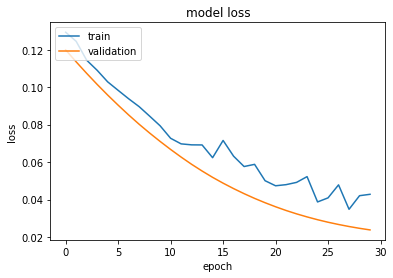

In [13]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
h2data = pd.read_csv('H2full.csv')
a=h2data.head()
a

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,...,No Deposit,6,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,...,No Deposit,9,NULL,0,Transient,68.0,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-04-02


In [15]:
t_leadtime = h2data['LeadTime'] #1
t_arrivaldateyear = h2data['ArrivalDateYear']
t_arrivaldateweekno = h2data['ArrivalDateWeekNumber']
t_arrivaldatedayofmonth = h2data['ArrivalDateDayOfMonth']
t_staysweekendnights = h2data['StaysInWeekendNights'] #2
t_staysweeknights = h2data['StaysInWeekNights'] #3
t_adults = h2data['Adults'] #4
t_children = h2data['Children'] #5
t_babies = h2data['Babies'] #6
t_isrepeatedguest = h2data['IsRepeatedGuest'] #11
t_previouscancellations = h2data['PreviousCancellations'] #12
t_previousbookingsnotcanceled = h2data['PreviousBookingsNotCanceled'] #13
t_bookingchanges = h2data['BookingChanges'] #16
t_agent = h2data['Agent'] #18
t_company = h2data['Company'] #19
t_dayswaitinglist = h2data['DaysInWaitingList'] #20
t_adr = h2data['ADR'] #22
t_rcps = h2data['RequiredCarParkingSpaces'] #23
t_totalsqr = h2data['TotalOfSpecialRequests'] #24

In [16]:
# Categorical variables
t_IsCanceled = h2data['IsCanceled']
t_arrivaldatemonth = h2data.ArrivalDateMonth.astype("category").cat.codes
t_arrivaldatemonthcat = pd.Series(t_arrivaldatemonth)
t_mealcat=h2data.Meal.astype("category").cat.codes
t_mealcat=pd.Series(t_mealcat)
t_countrycat=h2data.Country.astype("category").cat.codes
t_countrycat=pd.Series(t_countrycat)
t_marketsegmentcat=h2data.MarketSegment.astype("category").cat.codes
t_marketsegmentcat=pd.Series(t_marketsegmentcat)
t_distributionchannelcat=h2data.DistributionChannel.astype("category").cat.codes
t_distributionchannelcat=pd.Series(t_distributionchannelcat)
t_reservedroomtypecat=h2data.ReservedRoomType.astype("category").cat.codes
t_reservedroomtypecat=pd.Series(t_reservedroomtypecat)
t_assignedroomtypecat=h2data.AssignedRoomType.astype("category").cat.codes
t_assignedroomtypecat=pd.Series(t_assignedroomtypecat)
t_deposittypecat=h2data.DepositType.astype("category").cat.codes
t_deposittypecat=pd.Series(t_deposittypecat)
t_customertypecat=h2data.CustomerType.astype("category").cat.codes
t_customertypecat=pd.Series(t_customertypecat)
t_reservationstatuscat=h2data.ReservationStatus.astype("category").cat.codes
t_reservationstatuscat=pd.Series(t_reservationstatuscat)

In [17]:
atest = np.column_stack((t_IsCanceled,t_countrycat,t_marketsegmentcat,t_deposittypecat,t_customertypecat,t_rcps,t_arrivaldateweekno))
atest = sm.add_constant(atest, prepend=True)
btest = t_adr
btest=btest.values

In [18]:
np.shape(atest)

(79330, 8)

In [19]:
scaler_atest = MinMaxScaler()
print(scaler_atest.fit(atest))
ascale=scaler_atest.transform(atest)

MinMaxScaler(copy=True, feature_range=(0, 1))


In [20]:
np.shape(ascale)

(79330, 8)

In [21]:
bpred = model.predict(ascale)
bpred

array([[0.20426159],
       [0.3143504 ],
       [0.3143504 ],
       ...,
       [0.19616216],
       [0.20034659],
       [0.19616216]], dtype=float32)

In [22]:
bpred = scaler_y.inverse_transform(bpred)

In [23]:
bpred

array([[ 69.916695],
       [107.599   ],
       [107.599   ],
       ...,
       [ 67.14435 ],
       [ 68.57664 ],
       [ 67.14435 ]], dtype=float32)

In [24]:
btest

array([  0.  ,  76.5 ,  68.  , ..., 157.71, 104.4 , 151.2 ])

In [25]:
np.shape(btest)

(79330,)

In [26]:
np.shape(bpred)

(79330, 1)

In [27]:
bpred=np.reshape(bpred, (79330,)) 

In [28]:
np.shape(bpred)

(79330,)

In [29]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html
mean_absolute_error(btest, bpred)

39.96544735161318

In [30]:
mean_squared_error(btest, bpred)

3007.125878992065

In [31]:
math.sqrt(mean_squared_error(btest, bpred))

54.83726724584354

In [32]:
np.mean(btest)

105.30446539770578

In [33]:
np.mean(bpred)

81.74778

In [34]:
np.max(btest)

5400.0

In [35]:
np.max(bpred)

126.16262